## Imports

In [1]:
!apt install -y ffmpeg
!pip install ffmpeg

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [21]:
import torch
import torchvision.datasets  as dsets
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils

import tqdm
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import animation
from IPython.display import HTML

### Data

In [3]:
batch_size = 64
image_size = 64
num_epochs = 50
torch.cuda.set_device("cuda:0")

Котиков возьмём с [Каггла](https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models)

И распакуем:

```shell
mv archive.zip cats.zip
unzip cats.zip
rm -rf cats/*.jpg  #потому что внутри дублирующая структура: все изображения есть в cats и в cats/cats
```

In [4]:
dset = dsets.ImageFolder(root="cats",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                           ]))
# cut the size of the dataset
dataset, _ = torch.utils.data.random_split(dset, [len(dset)//2, len(dset)-len(dset)//2])
del _
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)

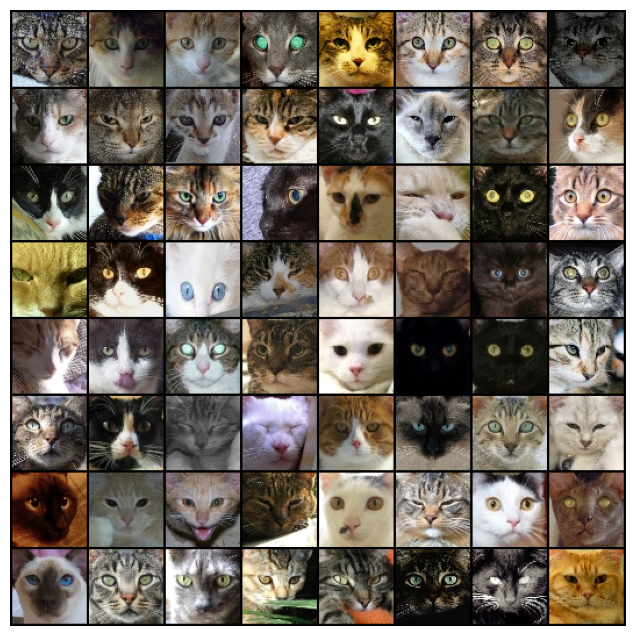

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2).cpu(),(1,2,0)))

### Model

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [7]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)
        self.z2h = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.z2h(z)
        return self.decoder(z), mu, logvar

In [8]:
def vae_loss(recon_x, x, mu, logvar) -> float:
    BCE = F.binary_cross_entropy(recon_x.view(-1, image_size*image_size*3),
                                 x.view(-1, image_size*image_size*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## training

In [11]:
model = VAE(z_dim=128)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [12]:
for epoch in range(num_epochs):
    train_loss = 0
    for data, _ in tqdm.tqdm(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    torch.save(model.state_dict(), "ckpts/cats_128.pth")
    print('epoch %d, loss %.7f' % (epoch, train_loss / len(dataset)))
model.eval()

100%|██████████| 123/123 [00:08<00:00, 13.83it/s]


epoch 0, loss 7833.9046980


100%|██████████| 123/123 [00:08<00:00, 13.88it/s]


epoch 1, loss 7387.5680332


100%|██████████| 123/123 [00:08<00:00, 13.76it/s]


epoch 2, loss 7264.4758629


100%|██████████| 123/123 [00:08<00:00, 13.85it/s]


epoch 3, loss 7186.5711331


100%|██████████| 123/123 [00:08<00:00, 13.77it/s]


epoch 4, loss 7130.0276261


100%|██████████| 123/123 [00:08<00:00, 13.68it/s]


epoch 5, loss 7098.0681443


100%|██████████| 123/123 [00:09<00:00, 13.63it/s]


epoch 6, loss 7073.1258534


100%|██████████| 123/123 [00:08<00:00, 13.89it/s]


epoch 7, loss 7054.8845183


100%|██████████| 123/123 [00:08<00:00, 13.80it/s]


epoch 8, loss 7036.0489728


100%|██████████| 123/123 [00:08<00:00, 13.86it/s]


epoch 9, loss 7022.8250945


100%|██████████| 123/123 [00:08<00:00, 13.82it/s]


epoch 10, loss 7017.3877810


100%|██████████| 123/123 [00:08<00:00, 13.88it/s]


epoch 11, loss 7005.7051196


100%|██████████| 123/123 [00:09<00:00, 13.60it/s]


epoch 12, loss 6993.9916050


100%|██████████| 123/123 [00:08<00:00, 13.92it/s]


epoch 13, loss 6991.0035604


100%|██████████| 123/123 [00:08<00:00, 13.90it/s]


epoch 14, loss 6979.7402793


100%|██████████| 123/123 [00:08<00:00, 13.81it/s]


epoch 15, loss 6977.8654857


100%|██████████| 123/123 [00:08<00:00, 13.75it/s]


epoch 16, loss 6971.8786279


100%|██████████| 123/123 [00:08<00:00, 13.94it/s]


epoch 17, loss 6963.7857829


100%|██████████| 123/123 [00:08<00:00, 13.82it/s]


epoch 18, loss 6956.9745650


100%|██████████| 123/123 [00:08<00:00, 13.81it/s]


epoch 19, loss 6960.3431387


100%|██████████| 123/123 [00:09<00:00, 13.56it/s]


epoch 20, loss 6949.7493609


100%|██████████| 123/123 [00:08<00:00, 13.72it/s]


epoch 21, loss 6946.6048520


100%|██████████| 123/123 [00:08<00:00, 13.74it/s]


epoch 22, loss 6941.2868268


100%|██████████| 123/123 [00:08<00:00, 13.85it/s]


epoch 23, loss 6937.5629962


100%|██████████| 123/123 [00:09<00:00, 13.62it/s]


epoch 24, loss 6938.5459402


100%|██████████| 123/123 [00:08<00:00, 13.97it/s]


epoch 25, loss 6934.1223485


100%|██████████| 123/123 [00:08<00:00, 13.70it/s]


epoch 26, loss 6932.6270561


100%|██████████| 123/123 [00:08<00:00, 13.67it/s]


epoch 27, loss 6928.3055459


100%|██████████| 123/123 [00:09<00:00, 13.46it/s]


epoch 28, loss 6926.3061174


100%|██████████| 123/123 [00:08<00:00, 14.02it/s]


epoch 29, loss 6925.3870348


100%|██████████| 123/123 [00:08<00:00, 13.69it/s]


epoch 30, loss 6921.2514051


100%|██████████| 123/123 [00:09<00:00, 13.65it/s]


epoch 31, loss 6919.3450718


100%|██████████| 123/123 [00:08<00:00, 14.02it/s]


epoch 32, loss 6918.2036470


100%|██████████| 123/123 [00:08<00:00, 13.94it/s]


epoch 33, loss 6919.5503779


100%|██████████| 123/123 [00:08<00:00, 14.03it/s]


epoch 34, loss 6915.0296424


100%|██████████| 123/123 [00:08<00:00, 14.20it/s]


epoch 35, loss 6911.5086728


100%|██████████| 123/123 [00:08<00:00, 13.70it/s]


epoch 36, loss 6910.9253739


100%|██████████| 123/123 [00:08<00:00, 13.69it/s]


epoch 37, loss 6908.1502286


100%|██████████| 123/123 [00:09<00:00, 13.50it/s]


epoch 38, loss 6909.2205838


100%|██████████| 123/123 [00:08<00:00, 14.00it/s]


epoch 39, loss 6907.3931554


100%|██████████| 123/123 [00:08<00:00, 13.84it/s]


epoch 40, loss 6906.7770346


100%|██████████| 123/123 [00:08<00:00, 13.87it/s]


epoch 41, loss 6904.0332545


100%|██████████| 123/123 [00:09<00:00, 13.49it/s]


epoch 42, loss 6903.0112926


100%|██████████| 123/123 [00:08<00:00, 13.81it/s]


epoch 43, loss 6903.2742006


100%|██████████| 123/123 [00:08<00:00, 13.88it/s]


epoch 44, loss 6904.0072280


100%|██████████| 123/123 [00:08<00:00, 13.80it/s]


epoch 45, loss 6900.3471556


100%|██████████| 123/123 [00:08<00:00, 13.81it/s]


epoch 46, loss 6899.4524721


100%|██████████| 123/123 [00:08<00:00, 13.91it/s]


epoch 47, loss 6897.5846644


100%|██████████| 123/123 [00:09<00:00, 13.42it/s]


epoch 48, loss 6894.8002429


100%|██████████| 123/123 [00:08<00:00, 13.73it/s]

epoch 49, loss 6896.4760812


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (h2mu): Linear(in_features=1024, out_features=128, bias=True)
  (h2sigma): Linear(in_features=1024, out_features=128, bias=True)
  (z2h): Linear(in_features=128, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)

### Visualizations time!

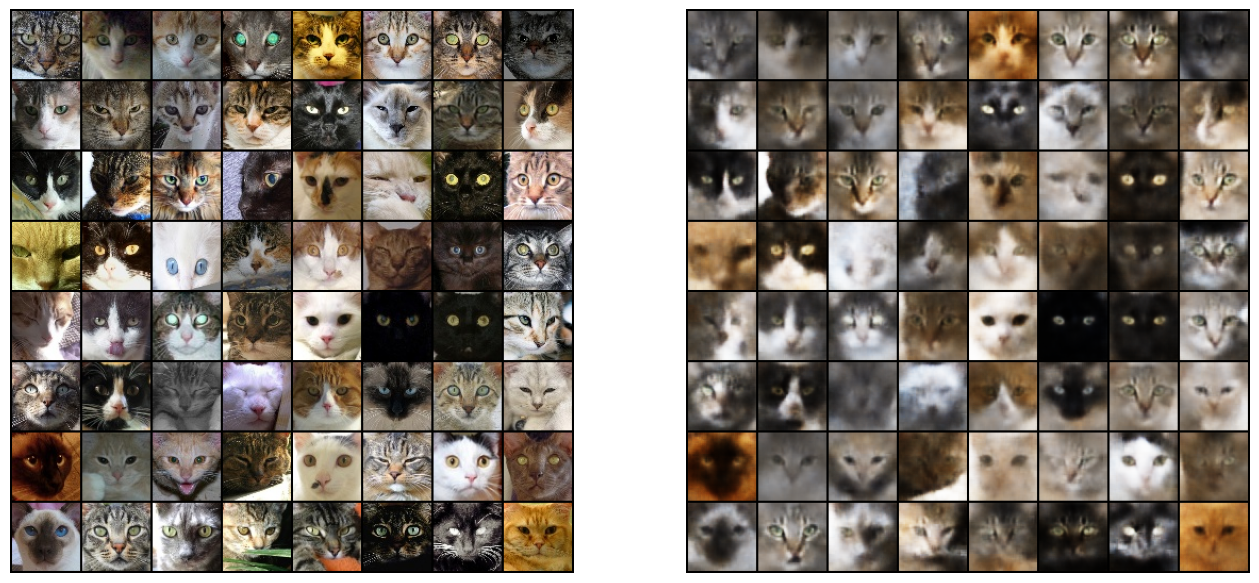

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 32))

axes[0].imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2).cpu(),(1,2,0)))

decoded_batch = model.decode(model.encode(real_batch[0]).data).data
axes[1].imshow(np.transpose(vutils.make_grid(decoded_batch, padding=2).cpu(),(1,2,0)))
axes[0].axis("off")
axes[1].axis("off")
plt.show()

# Создадим гифку

In [89]:
def get(x):
    return dataset[x][0].view(1, 3, image_size, image_size)

def imshow(img):
    pic = np.transpose(img.numpy(), (1,2,0))
    plt.axis('off')
    return plt.imshow(pic, animated=True)

def morph(inputs, steps: int, delay: int):
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            morphed = model.decode(c).data[0]
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

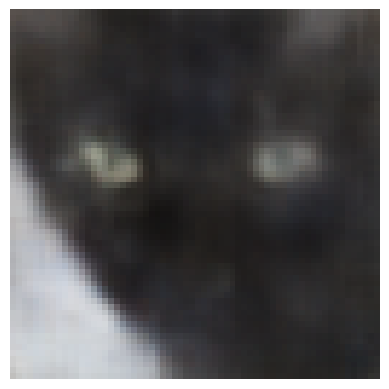

In [90]:
num_images = 5 # amount of images in GIF
num_steps = 100 # smoothness of transition between images
delay = 30
morph(np.random.randint(0, len(dataset), num_images), num_steps, delay)